In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('ggplot')

from scipy import stats

In [2]:
df = pd.read_csv('loan_data_core.csv')

C:\Users\leero\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (19,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df.drop(['id', 'member_id', 'url', 'emp_title'], axis=1, inplace=True)

In [4]:
df['loan_status'] = df.loan_status.apply(
    lambda loan_stat: 1 if loan_stat == 'Fully Paid' else 0)

df['int_rate'] = df.int_rate.apply(lambda interest: interest[:len(interest)-1])
df['int_rate'] = pd.to_numeric(df['int_rate'])

df['revol_util'].fillna('0%', inplace=True)
df['revol_util'] = df['revol_util'].apply(
    lambda interest: interest[:len(interest)-1])
df['revol_util'] = pd.to_numeric(df['revol_util'])

In [5]:
numeric = []

for column in df:
    if ((df[column].dtypes == 'float64') | (df[column].dtypes == 'int64')):
        numeric.append(column)

# removed dates and useless stats (columns that contained only 1 value)
numeric.remove('loan_status')
numeric.remove('next_pymnt_d')
numeric.remove('out_prncp')
numeric.remove('out_prncp_inv')
numeric.remove('collections_12_mths_ex_med')
numeric.remove('policy_code')
numeric.remove('acc_now_delinq')
numeric.remove('chargeoff_within_12_mths')
numeric.remove('delinq_amnt')
numeric.remove('num_tl_120dpd_2m')
numeric.remove('num_tl_30dpd')
numeric.remove('deferral_term')
numeric.remove('hardship_length')

objects = []
for column in df:
    if (df[column].dtypes == 'object'):
        objects.append(column)

# removed dates and useless stats (columns where the feature size was very small)
objects.remove('last_pymnt_d')
objects.remove('last_credit_pull_d')
objects.remove('desc')
objects.remove('title')
objects.remove('zip_code')
objects.remove('addr_state')
objects.remove('earliest_cr_line')
objects.remove('sec_app_earliest_cr_line')
objects.remove('hardship_reason')
objects.remove('hardship_start_date')
objects.remove('hardship_end_date')
objects.remove('payment_plan_start_date')
objects.remove('debt_settlement_flag_date')
objects.remove('settlement_date')
objects.remove('hardship_flag')
objects.remove('hardship_type')
objects.remove('issue_d')
objects.remove('debt_settlement_flag')

In [6]:
def percentage(feature):
    """Prints out number of samples, percent of total that failed, t-stat, and p-value"""

    all_loans = df[feature].value_counts().sort_index()
    bad_loans = df.loc[df.loan_status ==0][feature].value_counts().sort_index() / all_loans * 100

    n_percent = pd.concat([all_loans, bad_loans], axis=1)
    n_percent.columns = ['n_samples', 'percent failed']

    n_percent.reset_index(inplace=True)
    n_percent['t_stat'] = n_percent['index'].apply(lambda set_of_feature: stats.ttest_1samp(
        df.loc[df[feature] == set_of_feature]['loan_status'], 0.8013590467531224)[0])
    n_percent['p_value'] = n_percent['index'].apply(lambda set_of_feature: stats.ttest_1samp(
        df.loc[df[feature] == set_of_feature]['loan_status'], 0.8013590467531224)[1])
    
#    n_percent.fillna(0, inplace=True)
    
    return(n_percent)


def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    # Number of data points: n
    n = len(data)

    # x-data for the ECDF: x
    x = np.sort(data)

    # y-data for the ECDF: y
    y = np.arange(1, n+1) / n

    return x, y

In [7]:
def object_graph(feature):
    """Makes a bar graph of a column complete with all it's features, each bar with show the its makeup as a percentage total
    and prints out the features with sample size and fail rate"""

    feature_interest = df[[feature, 'loan_status']].dropna()

    x = sorted(list(set(feature_interest[feature])))
    y = [len(feature_interest.loc[feature_interest[feature] == i]) /2507640*100 for i in x]
    
    plt.bar(x, y)

    plt.title(feature.upper())
    plt.ylabel('%')
    plt.xlabel(feature)
    plt.xticks(rotation=90)

    plt.show()
    print(percentage(feature))


def numeric_graph(feature):
    """Makes a graph of a numeric column by turning the data into a ECDF"""
    #There will be 3 diffent CDF curves: Green = loans that were paid off, Red = Charged off loans,and Black = All the loans

    feature_interest = df[[feature, 'loan_status']].dropna()

    # good loans
    good_x, good_y = ecdf(
        feature_interest.loc[feature_interest.loan_status == 1][feature])
    plt.plot(good_x, good_y, marker='.', linestyle='none',
             color='green', label='Fully Paid')

    # population
    pop_x, pop_y = ecdf(feature_interest[feature])
    plt.plot(pop_x, pop_y, marker='.', linestyle='none',
             color='black', label='All loans')

    # bad loans
    bad_x, bad_y = ecdf(
        feature_interest.loc[feature_interest.loan_status == 0][feature])
    plt.plot(bad_x, bad_y, marker='.', linestyle='none',
             color='red', label='Charged Off')

    plt.title(feature.upper())
    plt.axis([np.percentile(pop_x, 2.5), np.percentile(pop_x, 97.5), 0, 1])
    plt.xlabel('Amounts')
    plt.ylabel('% cumulative')
    plt.legend(loc='best')

    plt.show()

    df_description = pd.concat([feature_interest[feature].describe(),
                                feature_interest.loc[feature_interest.loan_status == 1][feature].describe(
    ),
        feature_interest.loc[feature_interest.loan_status == 0][feature].describe()],
        axis=1)
    df_description.columns = ['All loans', 'Fully Paid', 'Charged Off']
    print(df_description)

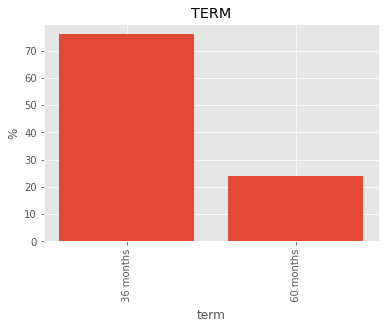

        index  n_samples  percent failed      t_stat  p_value
0   36 months    1904562       15.911480  149.127714      0.0
1   60 months     603078       32.346728 -207.220631      0.0


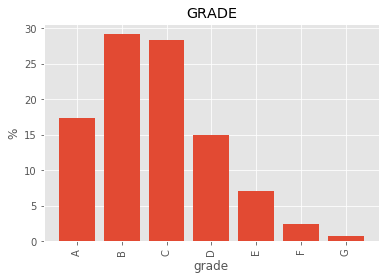

  index  n_samples  percent failed      t_stat  p_value
0     A     434114        5.989210  385.262877      0.0
1     B     731908       13.260137  166.590005      0.0
2     C     711534       22.216507  -47.734153      0.0
3     D     374050       30.109344 -136.592400      0.0
4     E     177466       38.392706 -160.493995      0.0
5     F      61314       45.046808 -125.328639      0.0
6     G      17254       49.913064  -78.939165      0.0


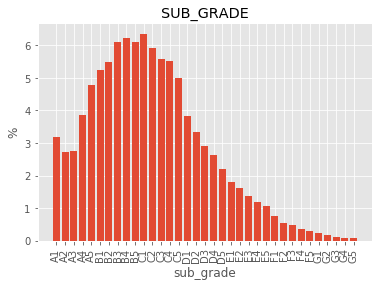

   index  n_samples  percent failed      t_stat        p_value
0     A1      79660        3.218679  266.181241   0.000000e+00
1     A2      68442        4.631659  189.608214   0.000000e+00
2     A3      69396        5.481584  166.451443   0.000000e+00
3     A4      97030        6.742245  163.005078   0.000000e+00
4     A5     119586        8.295285  145.049268   0.000000e+00
5     B1     131774       10.266062  114.792943   0.000000e+00
6     B2     137888       11.251160  101.212192   0.000000e+00
7     B3     153242       12.862009   81.876028   0.000000e+00
8     B4     156188       14.705355   57.566187   0.000000e+00
9     B5     152816       16.576798   34.556376  1.168816e-260
10    C1     159434       18.791475   10.963619   5.849759e-28
11    C2     148146       20.579698   -6.812875   9.603042e-12
12    C3     140024       22.303319  -21.926303  2.204573e-106
13    C4     138548       24.688916  -41.648496   0.000000e+00
14    C5     125382       25.676732  -47.114736   0.000

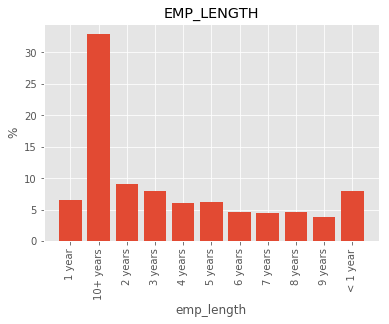

        index  n_samples  percent failed     t_stat        p_value
0      1 year     164812       20.469383  -6.090257   1.129779e-09
1   10+ years     824588       18.725230  26.509353  8.785826e-155
2     2 years     226758       19.733813   1.558811   1.190424e-01
3     3 years     200576       19.910657  -0.522203   6.015293e-01
4     4 years     150192       19.701449   1.584761   1.130228e-01
5     5 years     157126       19.511729   3.524539   4.243409e-04
6     6 years     117608       19.248691   5.353059   8.664096e-08
7     7 years     112658       19.442916   3.572020   3.543863e-04
8     8 years     115110       19.881852  -0.150947   8.800174e-01
9     9 years      95802       19.876412  -0.095526   9.238973e-01
10   < 1 year     199366       20.336467  -5.240110   1.606436e-07


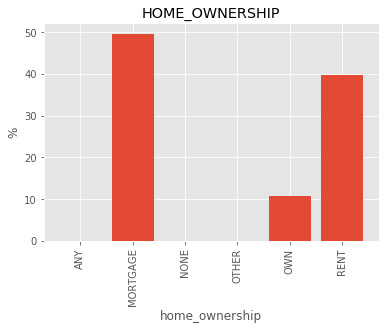

      index  n_samples  percent failed     t_stat       p_value
0       ANY        518       19.305019   0.322076  7.475256e-01
1  MORTGAGE    1242936       17.133947  80.778048  0.000000e+00
2      NONE         96       14.583333   1.458340  1.480452e-01
3     OTHER        288       18.750000   0.483561  6.290664e-01
4       OWN     266898       20.517201  -8.355258  6.559682e-17
5      RENT     996904       23.094300 -76.528785  0.000000e+00


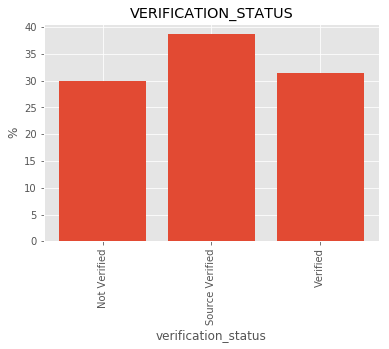

             index  n_samples  percent failed      t_stat        p_value
0     Not Verified     749220       14.468647  132.756337   0.000000e+00
1  Source Verified     969034       20.935282  -25.918129  4.675680e-148
2         Verified     789386       23.670042  -79.553655   0.000000e+00


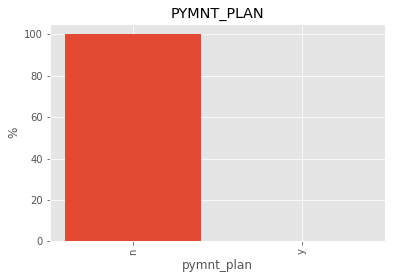

  index  n_samples  percent failed    t_stat   p_value
0     n    2507638       19.864111 -0.000629  0.999498
1     y          2             NaN       inf  0.000000


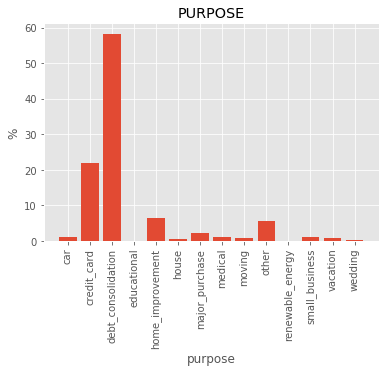

                 index  n_samples  percent failed     t_stat        p_value
0                  car      27082       14.400709  25.607504  6.334079e-143
1          credit_card     551450       16.858827  59.609327   0.000000e+00
2   debt_consolidation    1461114       21.066255 -35.635184  5.268528e-278
3          educational        652       17.177914   1.817053   6.966871e-02
4     home_improvement     161660       17.622170  23.658446  1.569464e-123
5                house      12736       21.278266  -3.899294   9.696873e-05
6       major_purchase      54082       18.165009  10.248270   1.268976e-24
7              medical      28352       21.621050  -7.186320   6.820440e-13
8               moving      17616       23.206176 -10.507353   9.522257e-26
9                other     141124       20.924860  -9.796408   1.186193e-22
10    renewable_energy       1744       23.279817  -3.374322   7.562013e-04
11      small_business      28818       29.308071 -35.220922  4.233367e-266
12          

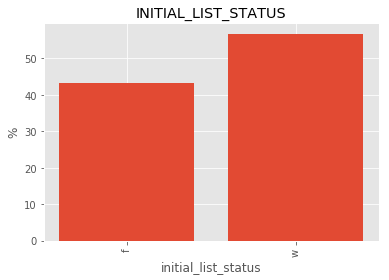

  index  n_samples  percent failed    t_stat       p_value
0     f    1084118       19.507471  9.370684  7.219544e-21
1     w    1423522       20.135692 -8.080647  6.447382e-16


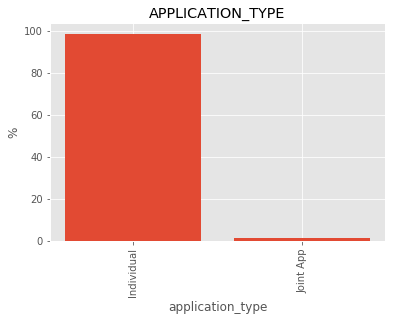

        index  n_samples  percent failed     t_stat       p_value
0  Individual    2471086       19.824158   1.574710  1.153235e-01
1   Joint App      36554       22.563878 -12.348428  5.832984e-35


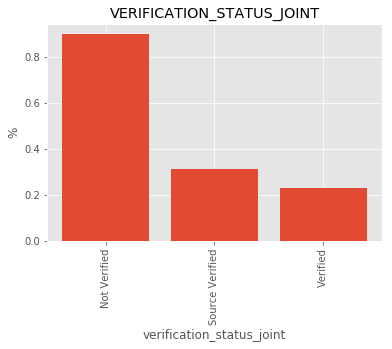

             index  n_samples  percent failed     t_stat       p_value
0     Not Verified      22572       21.664009  -6.564126  5.347559e-11
1  Source Verified       7894       23.030149  -6.680834  2.537080e-11
2         Verified       5834       25.917038 -10.550200  8.644041e-26


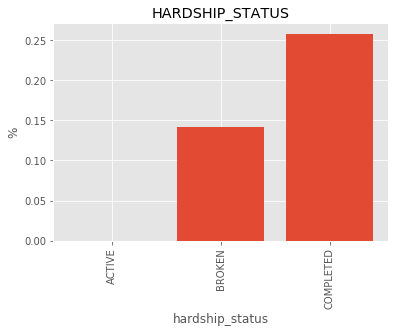

       index  n_samples  percent failed      t_stat  p_value
0     ACTIVE          2             NaN         inf      0.0
1     BROKEN       3564       95.286195 -212.425058      0.0
2  COMPLETED       6462       57.969669  -62.052111      0.0


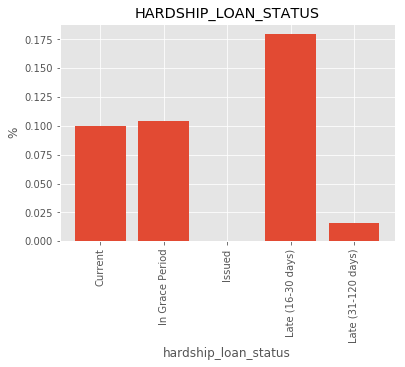

                index  n_samples  percent failed      t_stat        p_value
0             Current       2510       50.278884  -30.469961  9.035383e-174
1     In Grace Period       2610       74.099617  -63.235329   0.000000e+00
2              Issued         10       60.000000   -2.457812   3.628866e-02
3   Late (16-30 days)       4502       80.808530 -103.825930   0.000000e+00
4  Late (31-120 days)        396       76.262626  -26.344753   5.150774e-89


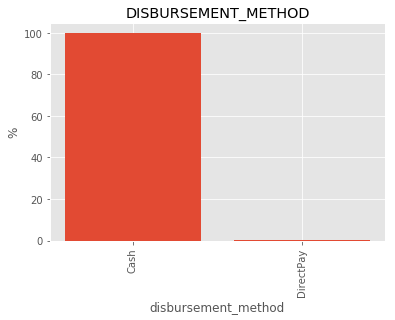

       index  n_samples  percent failed    t_stat   p_value
0       Cash    2498216       19.856410  0.304522  0.760730
1  DirectPay       9424       21.901528 -4.782108  0.000002


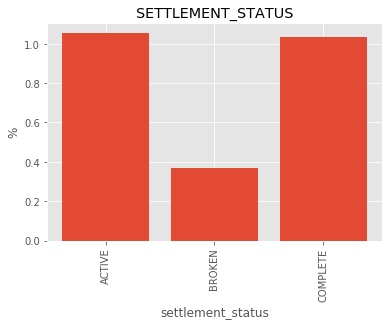

      index  n_samples  percent failed       t_stat  p_value
0    ACTIVE      26374       99.977250 -8626.713686      0.0
1    BROKEN       9216       99.978299 -5221.082458      0.0
2  COMPLETE      25894      100.000000         -inf      0.0


In [8]:
for thing in objects:
    object_graph(thing)

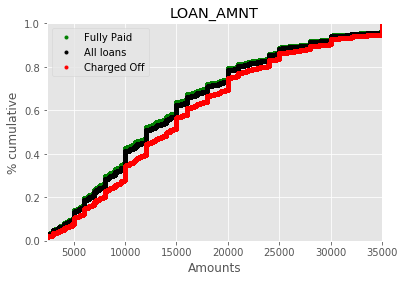

          All loans    Fully Paid    Charged Off
count  2.507640e+06  2.009520e+06  498120.000000
mean   1.441101e+04  1.413918e+04   15507.632097
std    8.663254e+03  8.621673e+03    8743.623101
min    5.000000e+02  5.000000e+02     900.000000
25%    8.000000e+03  7.500000e+03    9000.000000
50%    1.200000e+04  1.200000e+04   14250.000000
75%    2.000000e+04  2.000000e+04   20200.000000
max    4.000000e+04  4.000000e+04   40000.000000


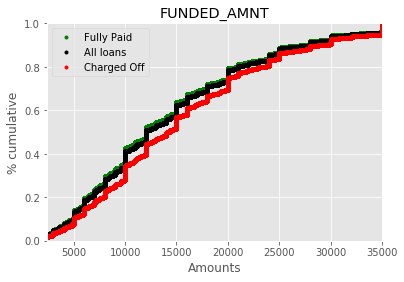

          All loans    Fully Paid    Charged Off
count  2.507640e+06  2.009520e+06  498120.000000
mean   1.440198e+04  1.413005e+04   15499.010479
std    8.658998e+03  8.617311e+03    8739.681715
min    5.000000e+02  5.000000e+02     900.000000
25%    8.000000e+03  7.500000e+03    9000.000000
50%    1.200000e+04  1.200000e+04   14225.000000
75%    2.000000e+04  2.000000e+04   20150.000000
max    4.000000e+04  4.000000e+04   40000.000000


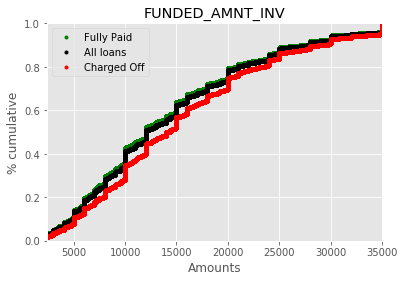

          All loans    Fully Paid    Charged Off
count  2.507640e+06  2.009520e+06  498120.000000
mean   1.437834e+04  1.410735e+04   15471.552311
std    8.661694e+03  8.619821e+03    8743.741887
min    0.000000e+00  0.000000e+00       0.000000
25%    7.950000e+03  7.500000e+03    9000.000000
50%    1.200000e+04  1.200000e+04   14125.000000
75%    2.000000e+04  2.000000e+04   20125.000000
max    4.000000e+04  4.000000e+04   40000.000000


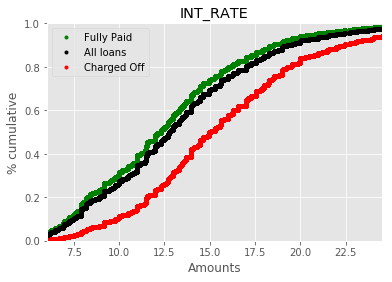

          All loans    Fully Paid    Charged Off
count  2.507640e+06  2.009520e+06  498120.000000
mean   1.324848e+01  1.264211e+01      15.694675
std    4.733669e+00  4.501023e+00       4.858772
min    5.310000e+00  5.310000e+00       5.310000
25%    9.750000e+00  9.170000e+00      12.290000
50%    1.279000e+01  1.229000e+01      15.050000
75%    1.599000e+01  1.531000e+01      18.550000
max    3.099000e+01  3.099000e+01      30.990000


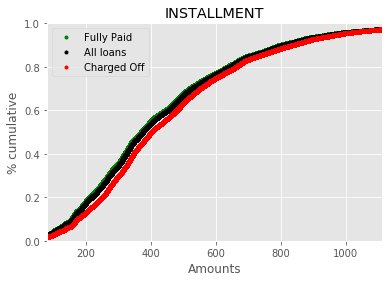

          All loans    Fully Paid    Charged Off
count  2.507640e+06  2.009520e+06  498120.000000
mean   4.380954e+02  4.318176e+02     463.421213
std    2.601662e+02  2.596661e+02     260.643363
min    4.930000e+00  4.930000e+00      21.620000
25%    2.495400e+02  2.425400e+02     275.330000
50%    3.754900e+02  3.695000e+02     402.540000
75%    5.799500e+02  5.734025e+02     602.080000
max    1.719830e+03  1.719830e+03    1717.630000


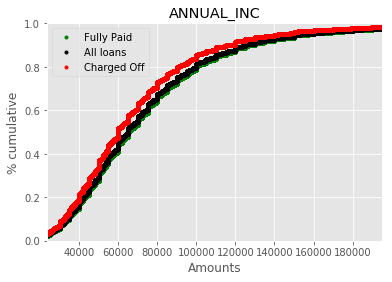

          All loans    Fully Paid   Charged Off
count  2.507640e+06  2.009520e+06  4.981200e+05
mean   7.609940e+04  7.755109e+04  7.024296e+04
std    6.969604e+04  7.058010e+04  6.568454e+04
min    0.000000e+00  0.000000e+00  0.000000e+00
25%    4.594575e+04  4.700000e+04  4.300000e+04
50%    6.500000e+04  6.500000e+04  6.000000e+04
75%    9.000000e+04  9.270000e+04  8.500000e+04
max    1.099920e+07  1.099920e+07  9.500000e+06


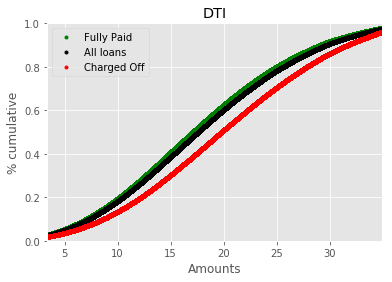

          All loans    Fully Paid    Charged Off
count  2.507172e+06  2.009138e+06  498034.000000
mean   1.822313e+01  1.774991e+01      20.132151
std    1.051788e+01  1.045924e+01      10.537612
min   -1.000000e+00 -1.000000e+00       0.000000
25%    1.181000e+01  1.143000e+01      13.630000
50%    1.761000e+01  1.709000e+01      19.800000
75%    2.401000e+01  2.339000e+01      26.310000
max    9.990000e+02  9.990000e+02     999.000000


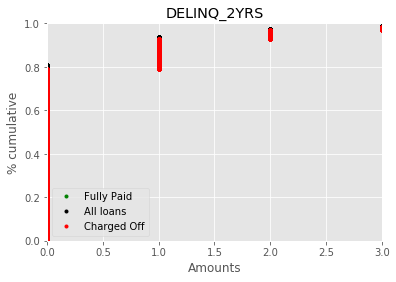

          All loans    Fully Paid    Charged Off
count  2.507640e+06  2.009520e+06  498120.000000
mean   3.190338e-01  3.102890e-01       0.354312
std    8.786840e-01  8.619411e-01       0.942393
min    0.000000e+00  0.000000e+00       0.000000
25%    0.000000e+00  0.000000e+00       0.000000
50%    0.000000e+00  0.000000e+00       0.000000
75%    0.000000e+00  0.000000e+00       0.000000
max    3.900000e+01  3.900000e+01      27.000000


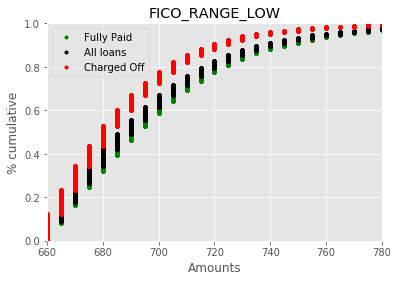

          All loans    Fully Paid    Charged Off
count  2.507640e+06  2.009520e+06  498120.000000
mean   6.958590e+02  6.979485e+02     687.429515
std    3.161433e+01  3.260976e+01      25.551707
min    6.250000e+02  6.250000e+02     660.000000
25%    6.700000e+02  6.750000e+02     670.000000
50%    6.900000e+02  6.900000e+02     680.000000
75%    7.100000e+02  7.150000e+02     700.000000
max    8.450000e+02  8.450000e+02     845.000000


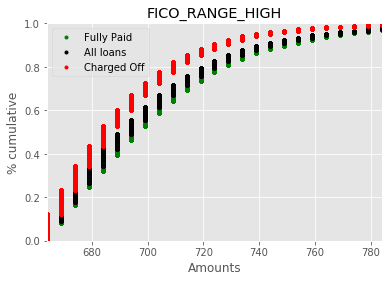

          All loans    Fully Paid    Charged Off
count  2.507640e+06  2.009520e+06  498120.000000
mean   6.998591e+02  7.019486e+02     691.429563
std    3.161493e+01  3.261042e+01      25.552005
min    6.290000e+02  6.290000e+02     664.000000
25%    6.740000e+02  6.790000e+02     674.000000
50%    6.940000e+02  6.940000e+02     684.000000
75%    7.140000e+02  7.190000e+02     704.000000
max    8.500000e+02  8.500000e+02     850.000000


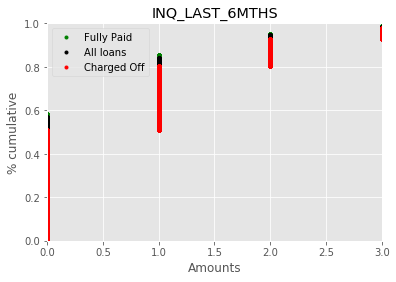

          All loans    Fully Paid    Charged Off
count  2.507638e+06  2.009518e+06  498120.000000
mean   6.620764e-01  6.313355e-01       0.786092
std    9.446772e-01  9.225609e-01       1.019717
min    0.000000e+00  0.000000e+00       0.000000
25%    0.000000e+00  0.000000e+00       0.000000
50%    0.000000e+00  0.000000e+00       0.000000
75%    1.000000e+00  1.000000e+00       1.000000
max    8.000000e+00  8.000000e+00       8.000000


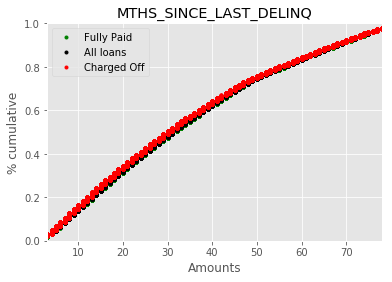

          All loans     Fully Paid    Charged Off
count  1.244114e+06  988054.000000  256060.000000
mean   3.426813e+01      34.410729      33.717879
std    2.192451e+01      21.909145      21.975060
min    0.000000e+00       0.000000       0.000000
25%    1.600000e+01      16.000000      15.000000
50%    3.100000e+01      31.000000      30.000000
75%    5.000000e+01      50.000000      49.000000
max    2.260000e+02     192.000000     226.000000


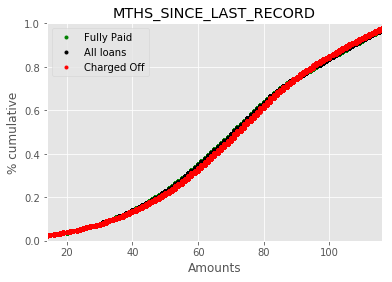

           All loans     Fully Paid   Charged Off
count  426228.000000  329686.000000  96542.000000
mean       70.417044      70.315482     70.763875
std        26.664615      26.738528     26.407839
min         0.000000       0.000000      0.000000
25%        53.000000      52.000000     53.000000
50%        71.000000      71.000000     72.000000
75%        90.000000      90.000000     90.000000
max       129.000000     123.000000    129.000000


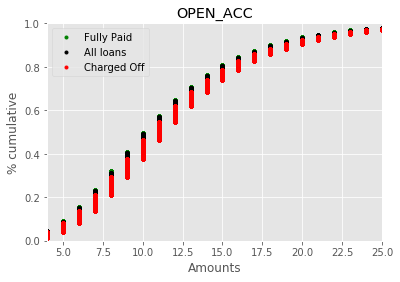

          All loans    Fully Paid    Charged Off
count  2.507640e+06  2.009520e+06  498120.000000
mean   1.159958e+01  1.151659e+01      11.934381
std    5.455954e+00  5.409710e+00       5.626248
min    0.000000e+00  0.000000e+00       0.000000
25%    8.000000e+00  8.000000e+00       8.000000
50%    1.100000e+01  1.100000e+01      11.000000
75%    1.400000e+01  1.400000e+01      15.000000
max    9.000000e+01  9.000000e+01      76.000000


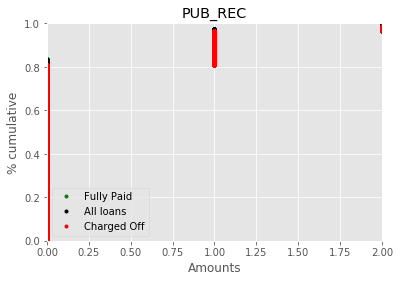

          All loans    Fully Paid    Charged Off
count  2.507640e+06  2.009520e+06  498120.000000
mean   2.158827e-01  2.078964e-01       0.248101
std    6.040937e-01  5.892308e-01       0.659687
min    0.000000e+00  0.000000e+00       0.000000
25%    0.000000e+00  0.000000e+00       0.000000
50%    0.000000e+00  0.000000e+00       0.000000
75%    0.000000e+00  0.000000e+00       0.000000
max    8.600000e+01  6.300000e+01      86.000000


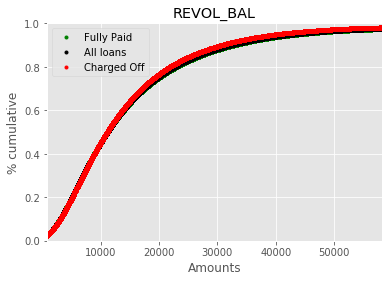

          All loans    Fully Paid   Charged Off
count  2.507640e+06  2.009520e+06  4.981200e+05
mean   1.627865e+04  1.649631e+04  1.540055e+04
std    2.224600e+04  2.299757e+04  1.888771e+04
min    0.000000e+00  0.000000e+00  0.000000e+00
25%    5.997000e+03  5.982000e+03  6.058750e+03
50%    1.119200e+04  1.120500e+04  1.114700e+04
75%    1.981700e+04  1.997800e+04  1.920200e+04
max    2.904836e+06  2.904836e+06  1.746716e+06


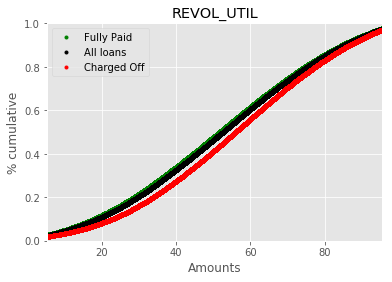

          All loans    Fully Paid    Charged Off
count  2.507640e+06  2.009520e+06  498120.000000
mean   5.217030e+01  5.141690e+01      55.209685
std    2.443677e+01  2.455029e+01      23.731766
min    0.000000e+00  0.000000e+00       0.000000
25%    3.400000e+01  3.300000e+01      38.000000
50%    5.260000e+01  5.170000e+01      56.000000
75%    7.100000e+01  7.040000e+01      73.500000
max    8.923000e+02  8.923000e+02     366.600000


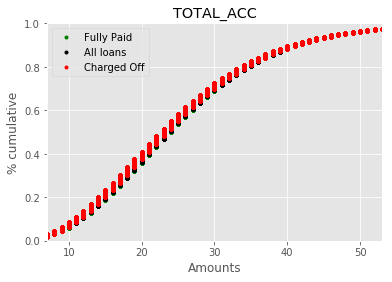

          All loans    Fully Paid    Charged Off
count  2.507640e+06  2.009520e+06  498120.000000
mean   2.507237e+01  2.512617e+01      24.855296
std    1.198443e+01  1.195395e+01      12.104191
min    2.000000e+00  2.000000e+00       2.000000
25%    1.600000e+01  1.600000e+01      16.000000
50%    2.300000e+01  2.300000e+01      23.000000
75%    3.200000e+01  3.200000e+01      32.000000
max    1.760000e+02  1.620000e+02     176.000000


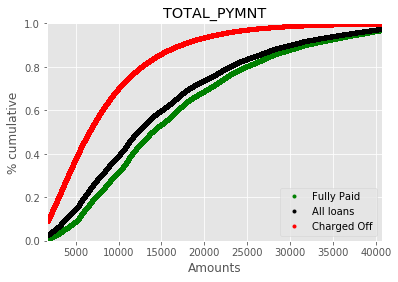

          All loans    Fully Paid    Charged Off
count  2.507640e+06  2.009520e+06  498120.000000
mean   1.485085e+04  1.647172e+04    8311.880318
std    1.031403e+04  1.042185e+04    6633.437691
min    0.000000e+00  5.263322e+02       0.000000
25%    6.896965e+03  8.487580e+03    3555.950000
50%    1.217796e+04  1.388977e+04    6572.815000
75%    2.059952e+04  2.245096e+04   11184.885000
max    6.294899e+04  6.294899e+04   61947.529800


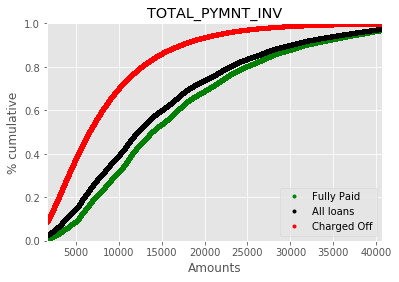

          All loans    Fully Paid    Charged Off
count  2.507640e+06  2.009520e+06  498120.000000
mean   1.482589e+04  1.644419e+04    8297.332482
std    1.031252e+04  1.042252e+04    6630.217524
min    0.000000e+00  0.000000e+00       0.000000
25%    6.878730e+03  8.461420e+03    3543.937500
50%    1.215451e+04  1.386224e+04    6559.390000
75%    2.057078e+04  2.242996e+04   11167.587500
max    6.290403e+04  6.290403e+04   61947.530000


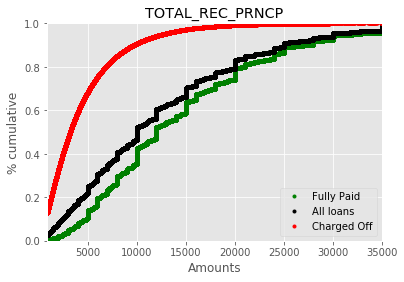

          All loans    Fully Paid    Charged Off
count  2.507640e+06  2.009520e+06  498120.000000
mean   1.219976e+04  1.413005e+04    4412.568982
std    8.825014e+03  8.617311e+03    4101.735149
min    0.000000e+00  5.000000e+02       0.000000
25%    5.093792e+03  7.500000e+03    1559.235000
50%    1.000000e+04  1.200000e+04    3204.720000
75%    1.737500e+04  2.000000e+04    5928.712500
max    4.000000e+04  4.000000e+04   37600.000000


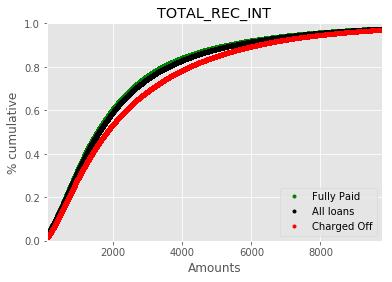

          All loans    Fully Paid    Charged Off
count  2.507640e+06  2.009520e+06  498120.000000
mean   2.413194e+03  2.340877e+03    2704.937532
std    2.599078e+03  2.561764e+03    2725.048139
min    0.000000e+00  0.000000e+00       0.000000
25%    7.808475e+02  7.614400e+02     868.987500
50%    1.587870e+03  1.539510e+03    1819.455000
75%    3.048460e+03  2.923390e+03    3597.980000
max    2.794899e+04  2.794899e+04   26822.380000


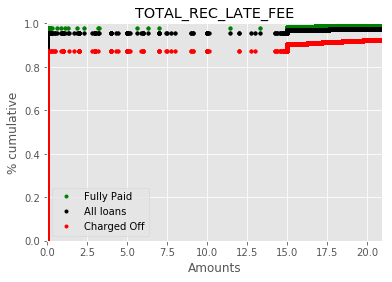

          All loans    Fully Paid   Charged Off
count  2.507640e+06  2.009520e+06  4.981200e+05
mean   1.523248e+00  7.969781e-01  4.453174e+00
std    1.041176e+01  8.221701e+00  1.619636e+01
min   -5.100000e-09  0.000000e+00 -5.100000e-09
25%    0.000000e+00  0.000000e+00  0.000000e+00
50%    0.000000e+00  0.000000e+00  0.000000e+00
75%    0.000000e+00  0.000000e+00  0.000000e+00
max    1.188830e+03  1.188830e+03  8.741700e+02


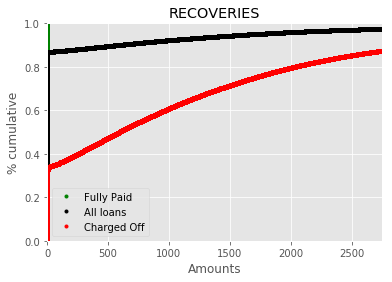

          All loans  Fully Paid    Charged Off
count  2.507640e+06   2009520.0  498120.000000
mean   2.363670e+02         0.0    1189.920628
std    9.371463e+02         0.0    1812.901307
min    0.000000e+00         0.0       0.000000
25%    0.000000e+00         0.0       0.000000
50%    0.000000e+00         0.0     594.485000
75%    0.000000e+00         0.0    1700.620000
max    3.985955e+04         0.0   39859.550000


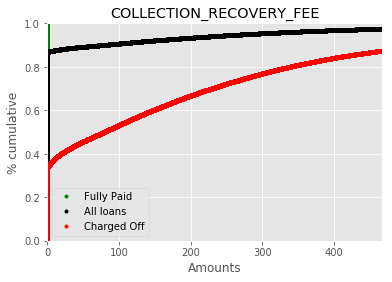

          All loans  Fully Paid    Charged Off
count  2.507640e+06   2009520.0  498120.000000
mean   3.920173e+01         0.0     197.349699
std    1.639968e+02         0.0     322.776125
min    0.000000e+00         0.0       0.000000
25%    0.000000e+00         0.0       0.000000
50%    0.000000e+00         0.0      79.033500
75%    0.000000e+00         0.0     278.808300
max    7.174719e+03         0.0    7174.719000


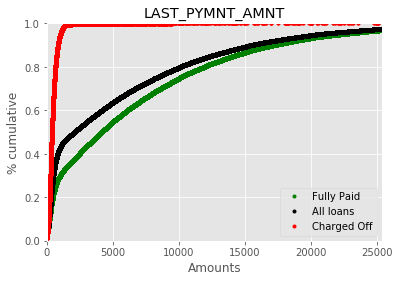

          All loans    Fully Paid    Charged Off
count  2.507640e+06  2.009520e+06  498120.000000
mean   5.424672e+03  6.652606e+03     470.928778
std    7.081722e+03  7.410268e+03     566.015907
min    0.000000e+00  0.000000e+00       0.000000
25%    4.001700e+02  6.546600e+02     256.037500
50%    2.088640e+03  4.146090e+03     389.865000
75%    8.271613e+03  1.005805e+04     596.820000
max    4.219205e+04  4.219205e+04   37600.000000


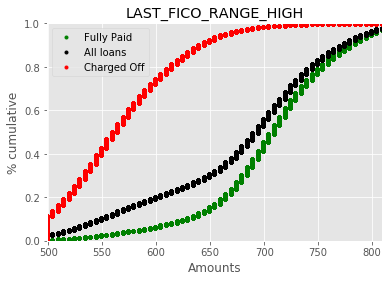

          All loans    Fully Paid    Charged Off
count  2.507640e+06  2.009520e+06  498120.000000
mean   6.770336e+02  7.039450e+02     568.467385
std    8.099676e+01  6.184022e+01      53.766440
min    0.000000e+00  0.000000e+00       0.000000
25%    6.290000e+02  6.740000e+02     524.000000
50%    6.940000e+02  7.090000e+02     559.000000
75%    7.340000e+02  7.440000e+02     604.000000
max    8.500000e+02  8.500000e+02     850.000000


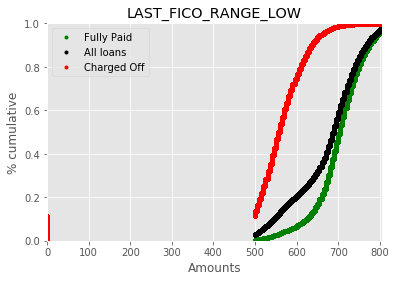

          All loans    Fully Paid    Charged Off
count  2.507640e+06  2.009520e+06  498120.000000
mean   6.602392e+02  6.978789e+02     508.393178
std    1.314728e+02  7.542508e+01     187.866347
min    0.000000e+00  0.000000e+00       0.000000
25%    6.250000e+02  6.700000e+02     520.000000
50%    6.900000e+02  7.050000e+02     555.000000
75%    7.300000e+02  7.400000e+02     600.000000
max    8.450000e+02  8.450000e+02     845.000000


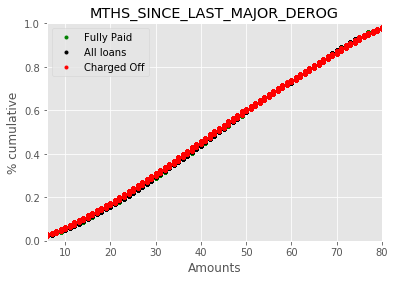

           All loans     Fully Paid    Charged Off
count  658410.000000  514742.000000  143668.000000
mean       43.647572      43.715143      43.405477
std        21.359458      21.305850      21.548767
min         0.000000       0.000000       0.000000
25%        27.000000      27.000000      26.000000
50%        44.000000      44.000000      43.000000
75%        61.000000      61.000000      61.000000
max       226.000000     192.000000     226.000000


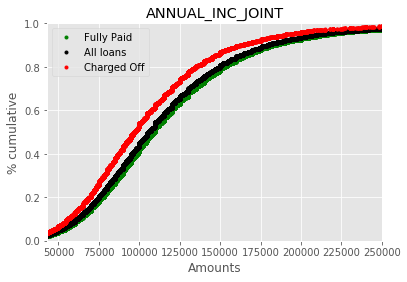

          All loans    Fully Paid    Charged Off
count  3.655400e+04  2.830600e+04    8248.000000
mean   1.163916e+05  1.194707e+05  105824.905601
std    5.704025e+04  5.861326e+04   49853.581894
min    1.100000e+04  1.100000e+04   15850.000000
25%    8.000000e+04  8.300000e+04   74000.000000
50%    1.060000e+05  1.092000e+05   97000.000000
75%    1.400000e+05  1.430000e+05  127000.000000
max    1.350000e+06  1.350000e+06  650000.000000


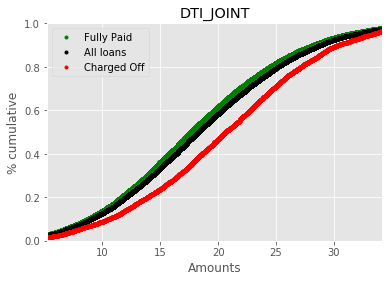

          All loans    Fully Paid  Charged Off
count  36552.000000  28304.000000  8248.000000
mean      18.686105     18.113038    20.652650
std        7.573205      7.441006     7.692684
min        0.000000      0.000000     0.770000
25%       13.217500     12.770000    15.340000
50%       18.265000     17.590000    20.600000
75%       23.832500     23.070000    25.830000
max       69.490000     61.900000    69.490000


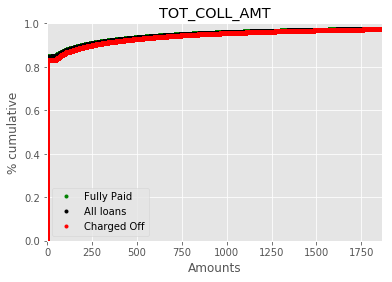

          All loans    Fully Paid    Charged Off
count  2.372586e+06  1.895102e+06  477484.000000
mean   2.495436e+02  2.525724e+02     237.522505
std    1.146587e+04  1.279908e+04    1752.307548
min    0.000000e+00  0.000000e+00       0.000000
25%    0.000000e+00  0.000000e+00       0.000000
50%    0.000000e+00  0.000000e+00       0.000000
75%    0.000000e+00  0.000000e+00       0.000000
max    9.152545e+06  9.152545e+06  146917.000000


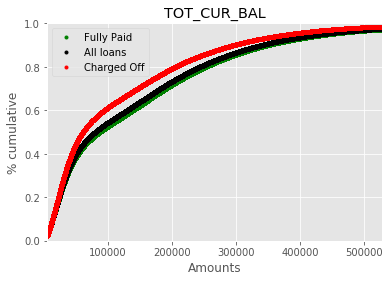

          All loans    Fully Paid   Charged Off
count  2.372586e+06  1.895102e+06  4.774840e+05
mean   1.409872e+05  1.466147e+05  1.186522e+05
std    1.570073e+05  1.618400e+05  1.338320e+05
min    0.000000e+00  0.000000e+00  0.000000e+00
25%    2.954400e+04  3.013100e+04  2.766300e+04
50%    8.044100e+04  8.761500e+04  6.152200e+04
75%    2.104650e+05  2.190310e+05  1.746030e+05
max    8.000078e+06  8.000078e+06  3.437283e+06


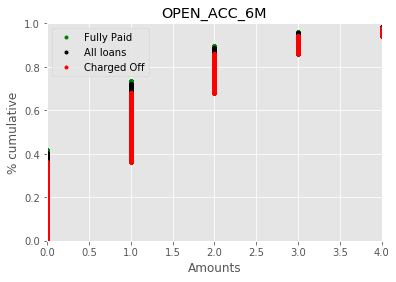

           All loans     Fully Paid    Charged Off
count  902852.000000  699332.000000  203520.000000
mean        1.058065       1.018272       1.194801
std         1.214448       1.184869       1.301775
min         0.000000       0.000000       0.000000
25%         0.000000       0.000000       0.000000
50%         1.000000       1.000000       1.000000
75%         2.000000       2.000000       2.000000
max        18.000000      16.000000      18.000000


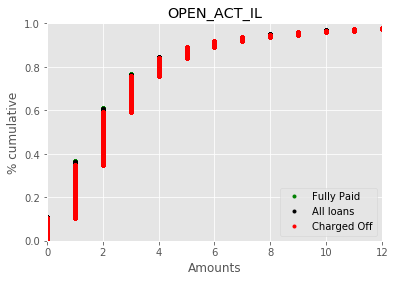

           All loans     Fully Paid    Charged Off
count  902854.000000  699334.000000  203520.000000
mean        2.810523       2.793346       2.869546
std         3.004407       2.984549       3.070941
min         0.000000       0.000000       0.000000
25%         1.000000       1.000000       1.000000
50%         2.000000       2.000000       2.000000
75%         3.000000       3.000000       3.000000
max        57.000000      53.000000      57.000000


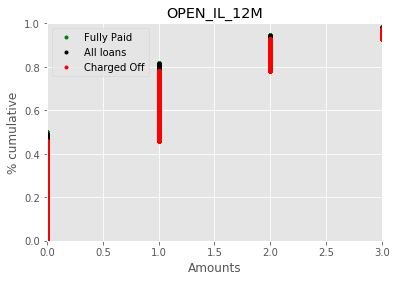

           All loans     Fully Paid    Charged Off
count  902854.000000  699334.000000  203520.000000
mean        0.785077       0.760913       0.868111
std         0.998134       0.979500       1.055466
min         0.000000       0.000000       0.000000
25%         0.000000       0.000000       0.000000
50%         1.000000       0.000000       1.000000
75%         1.000000       1.000000       1.000000
max        25.000000      20.000000      25.000000


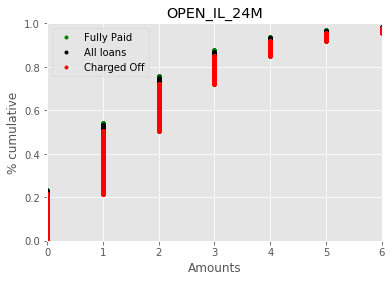

           All loans     Fully Paid    Charged Off
count  902854.000000  699334.000000  203520.000000
mean        1.759733       1.722084       1.889102
std         1.693012       1.661985       1.789522
min         0.000000       0.000000       0.000000
25%         1.000000       1.000000       1.000000
50%         1.000000       1.000000       1.000000
75%         3.000000       2.000000       3.000000
max        51.000000      30.000000      51.000000


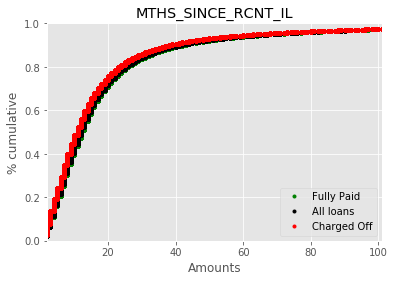

           All loans     Fully Paid    Charged Off
count  879998.000000  682496.000000  197502.000000
mean       19.407771      19.706299      18.376168
std        24.603680      24.562077      24.719228
min         0.000000       0.000000       0.000000
25%         6.000000       6.000000       6.000000
50%        12.000000      12.000000      11.000000
75%        22.000000      22.000000      20.000000
max       511.000000     488.000000     511.000000


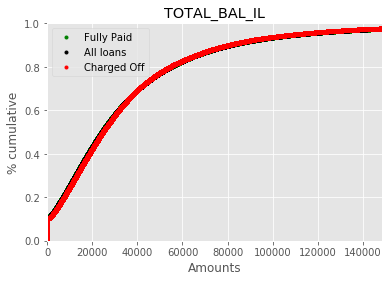

          All loans    Fully Paid    Charged Off
count  9.028540e+05  6.993340e+05  203520.000000
mean   3.606312e+04  3.610227e+04   35928.570666
std    4.288981e+04  4.333407e+04   41326.679780
min    0.000000e+00  0.000000e+00       0.000000
25%    9.859000e+03  9.721000e+03   10326.750000
50%    2.432900e+04  2.418500e+04   24779.500000
75%    4.695300e+04  4.700275e+04   46765.250000
max    1.711009e+06  1.711009e+06  796104.000000


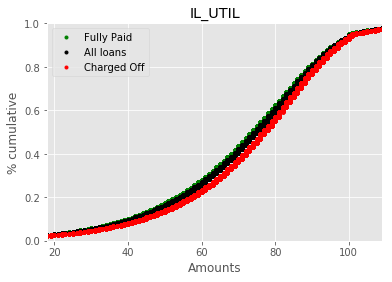

           All loans     Fully Paid   Charged Off
count  783574.000000  604830.000000  178744.00000
mean       71.670004      71.067794      73.70775
std        22.775452      22.821431      22.50001
min         0.000000       0.000000       0.00000
25%        59.000000      58.000000      62.00000
50%        75.000000      74.000000      77.00000
75%        87.000000      87.000000      89.00000
max       558.000000     464.000000     558.00000


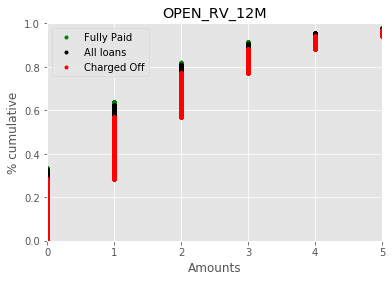

           All loans     Fully Paid    Charged Off
count  902854.000000  699334.000000  203520.000000
mean        1.436106       1.381783       1.622769
std         1.582616       1.544811       1.692919
min         0.000000       0.000000       0.000000
25%         0.000000       0.000000       0.000000
50%         1.000000       1.000000       1.000000
75%         2.000000       2.000000       2.000000
max        28.000000      28.000000      26.000000


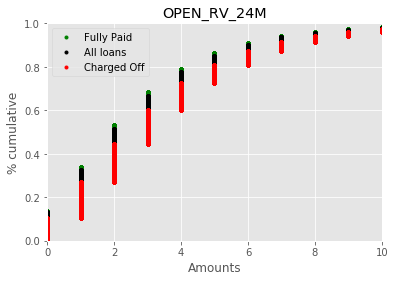

           All loans     Fully Paid    Charged Off
count  902854.000000  699334.000000  203520.000000
mean        3.036376       2.914713       3.454432
std         2.714445       2.639579       2.918897
min         0.000000       0.000000       0.000000
25%         1.000000       1.000000       1.000000
50%         2.000000       2.000000       3.000000
75%         4.000000       4.000000       5.000000
max        53.000000      53.000000      49.000000


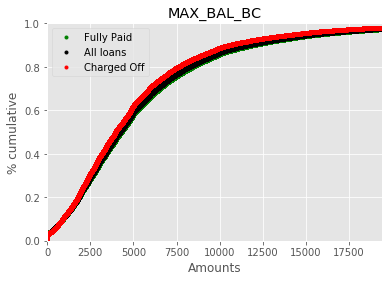

           All loans     Fully Paid    Charged Off
count  902854.000000  699334.000000  203520.000000
mean     5549.137739    5659.644951    5169.413630
std      5490.696393    5662.023826    4836.936491
min         0.000000       0.000000       0.000000
25%      2203.000000    2235.000000    2102.000000
50%      4217.000000    4297.000000    3962.000000
75%      7203.000000    7369.000000    6688.250000
max    776843.000000  776843.000000  208872.000000


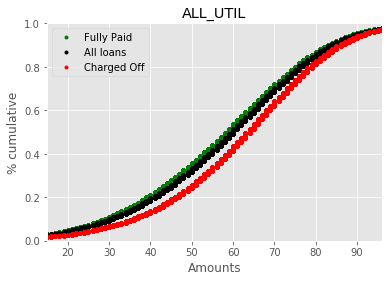

           All loans     Fully Paid    Charged Off
count  902774.000000  699264.000000  203510.000000
mean       58.539736      57.456637      62.261284
std        20.814758      20.957823      19.870608
min         0.000000       0.000000       0.000000
25%        45.000000      43.000000      50.000000
50%        60.000000      59.000000      64.000000
75%        73.000000      72.000000      76.000000
max       198.000000     198.000000     184.000000


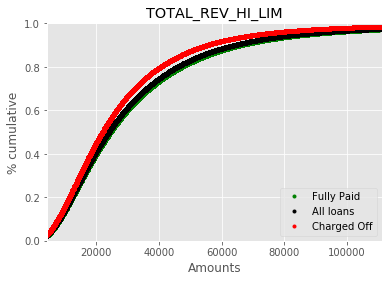

          All loans    Fully Paid   Charged Off
count  2.372586e+06  1.895102e+06  4.774840e+05
mean   3.260832e+04  3.357595e+04  2.876786e+04
std    3.667124e+04  3.853346e+04  2.775743e+04
min    0.000000e+00  0.000000e+00  0.000000e+00
25%    1.400000e+04  1.430000e+04  1.300000e+04
50%    2.400000e+04  2.450000e+04  2.200000e+04
75%    4.040000e+04  4.160000e+04  3.590000e+04
max    9.999999e+06  9.999999e+06  1.998700e+06


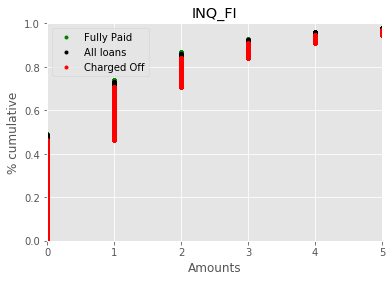

           All loans     Fully Paid    Charged Off
count  902854.000000  699334.000000  203520.000000
mean        1.094476       1.061724       1.207017
std         1.591920       1.552212       1.716648
min         0.000000       0.000000       0.000000
25%         0.000000       0.000000       0.000000
50%         1.000000       1.000000       1.000000
75%         2.000000       2.000000       2.000000
max        48.000000      48.000000      28.000000


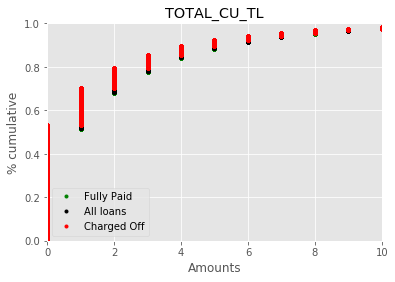

           All loans     Fully Paid    Charged Off
count  902852.000000  699332.000000  203520.000000
mean        1.627020       1.651227       1.543838
std         2.840274       2.857130       2.779979
min         0.000000       0.000000       0.000000
25%         0.000000       0.000000       0.000000
50%         0.000000       0.000000       0.000000
75%         2.000000       2.000000       2.000000
max        79.000000      79.000000      54.000000


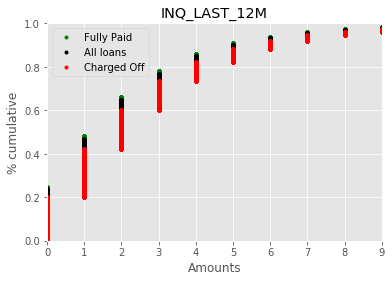

           All loans     Fully Paid    Charged Off
count  902852.000000  699332.000000  203520.000000
mean        2.337070       2.256267       2.614721
std         2.560217       2.495080       2.754400
min         0.000000       0.000000       0.000000
25%         1.000000       1.000000       1.000000
50%         2.000000       2.000000       2.000000
75%         3.000000       3.000000       4.000000
max        67.000000      67.000000      40.000000


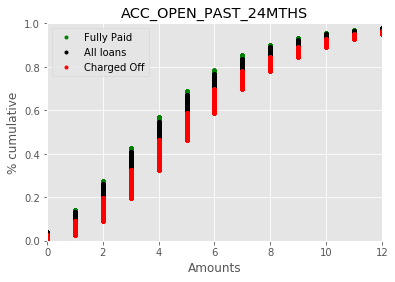

          All loans    Fully Paid    Charged Off
count  2.413078e+06  1.928730e+06  484348.000000
mean   4.688353e+00  4.525386e+00       5.337307
std    3.178227e+00  3.095034e+00       3.413576
min    0.000000e+00  0.000000e+00       0.000000
25%    2.000000e+00  2.000000e+00       3.000000
50%    4.000000e+00  4.000000e+00       5.000000
75%    6.000000e+00  6.000000e+00       7.000000
max    6.400000e+01  5.400000e+01      64.000000


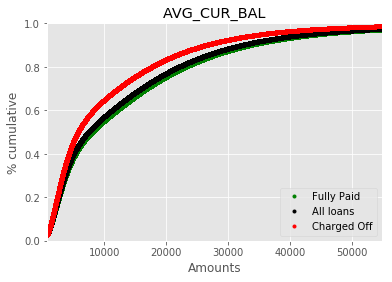

          All loans    Fully Paid    Charged Off
count  2.372550e+06  1.895076e+06  477474.000000
mean   1.346558e+04  1.411700e+04   10880.096499
std    1.620906e+04  1.684071e+04   13096.143537
min    0.000000e+00  0.000000e+00       0.000000
25%    3.107000e+03  3.201000e+03    2808.000000
50%    7.417000e+03  8.026500e+03    5752.000000
75%    1.870075e+04  1.969500e+04   14700.000000
max    9.580840e+05  9.580840e+05  355824.000000


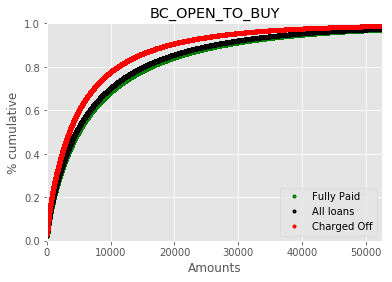

          All loans    Fully Paid    Charged Off
count  2.387790e+06  1.908718e+06  479072.000000
mean   9.996360e+03  1.062796e+04    7479.931543
std    1.513031e+04  1.581189e+04   11703.882695
min    0.000000e+00  0.000000e+00       0.000000
25%    1.423000e+03  1.537250e+03    1061.000000
50%    4.588000e+03  4.940000e+03    3480.000000
75%    1.210900e+04  1.301700e+04    8911.250000
max    5.599120e+05  5.599120e+05  293031.000000


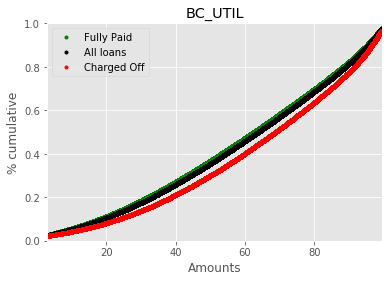

          All loans    Fully Paid    Charged Off
count  2.386342e+06  1.907586e+06  478756.000000
mean   6.044169e+01  5.947751e+01      64.283428
std    2.812853e+01  2.823074e+01      27.382505
min    0.000000e+00  0.000000e+00       0.000000
25%    3.900000e+01  3.780000e+01      44.600000
50%    6.380000e+01  6.250000e+01      68.800000
75%    8.510000e+01  8.430000e+01      88.300000
max    3.396000e+02  3.396000e+02     255.200000


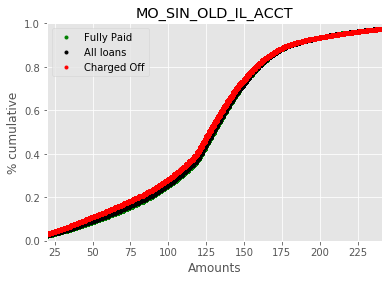

          All loans    Fully Paid    Charged Off
count  2.302254e+06  1.839598e+06  462656.000000
mean   1.259644e+02  1.266374e+02     123.288556
std    5.210205e+01  5.156621e+01      54.097547
min    0.000000e+00  0.000000e+00       0.000000
25%    9.800000e+01  9.900000e+01      93.000000
50%    1.290000e+02  1.300000e+02     127.000000
75%    1.520000e+02  1.530000e+02     151.000000
max    9.990000e+02  9.990000e+02     720.000000


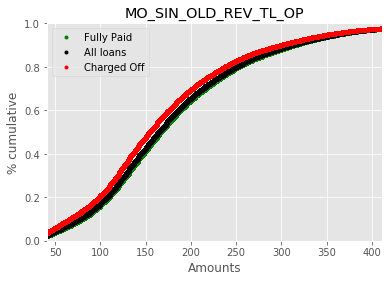

          All loans    Fully Paid    Charged Off
count  2.372584e+06  1.895102e+06  477482.000000
mean   1.816926e+02  1.841002e+02     172.136809
std    9.415688e+01  9.397449e+01      94.273031
min    2.000000e+00  2.000000e+00       2.000000
25%    1.170000e+02  1.200000e+02     110.000000
50%    1.640000e+02  1.670000e+02     154.000000
75%    2.300000e+02  2.330000e+02     218.000000
max    8.510000e+02  8.510000e+02     842.000000


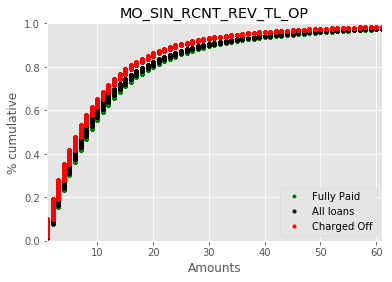

          All loans    Fully Paid    Charged Off
count  2.372584e+06  1.895102e+06  477482.000000
mean   1.306656e+01  1.351944e+01      11.269128
std    1.624667e+01  1.665889e+01      14.355228
min    0.000000e+00  0.000000e+00       0.000000
25%    4.000000e+00  4.000000e+00       3.000000
50%    8.000000e+00  8.000000e+00       7.000000
75%    1.600000e+01  1.600000e+01      14.000000
max    4.380000e+02  4.380000e+02     372.000000


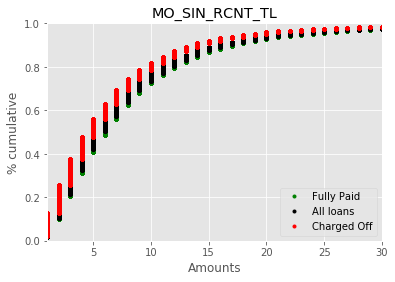

          All loans    Fully Paid    Charged Off
count  2.372586e+06  1.895102e+06  477484.000000
mean   7.849721e+00  8.100625e+00       6.853901
std    8.706316e+00  8.901067e+00       7.806976
min    0.000000e+00  0.000000e+00       0.000000
25%    3.000000e+00  3.000000e+00       2.000000
50%    5.000000e+00  6.000000e+00       5.000000
75%    1.000000e+01  1.000000e+01       9.000000
max    3.140000e+02  3.140000e+02     289.000000


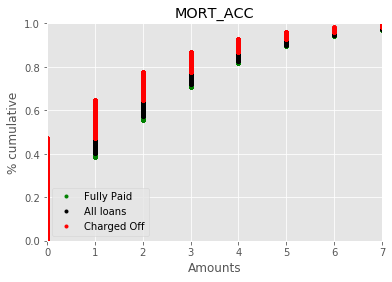

          All loans    Fully Paid    Charged Off
count  2.413078e+06  1.928730e+06  484348.000000
mean   1.685370e+00  1.760621e+00       1.385714
std    2.012596e+00  2.047229e+00       1.838019
min    0.000000e+00  0.000000e+00       0.000000
25%    0.000000e+00  0.000000e+00       0.000000
50%    1.000000e+00  1.000000e+00       1.000000
75%    3.000000e+00  3.000000e+00       2.000000
max    5.100000e+01  5.100000e+01      29.000000


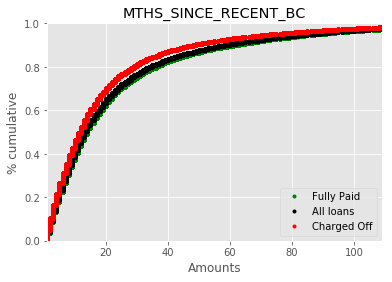

          All loans    Fully Paid    Charged Off
count  2.389502e+06  1.910066e+06  479436.000000
mean   2.379957e+01  2.460975e+01      20.571805
std    3.060687e+01  3.126781e+01      27.583014
min    0.000000e+00  0.000000e+00       0.000000
25%    6.000000e+00  6.000000e+00       5.000000
50%    1.300000e+01  1.400000e+01      12.000000
75%    2.800000e+01  3.000000e+01      24.000000
max    6.390000e+02  6.390000e+02     611.000000


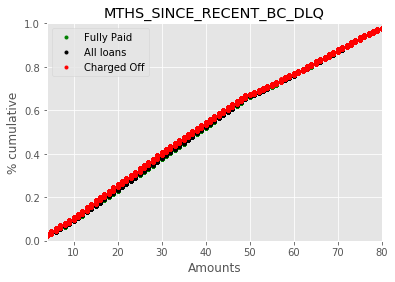

           All loans     Fully Paid    Charged Off
count  596230.000000  471434.000000  124796.000000
mean       39.696932      39.827755      39.202731
std        22.717589      22.666285      22.903708
min         0.000000       0.000000       0.000000
25%        21.000000      21.000000      20.000000
50%        38.000000      38.000000      37.000000
75%        59.000000      59.000000      58.000000
max       189.000000     189.000000     170.000000


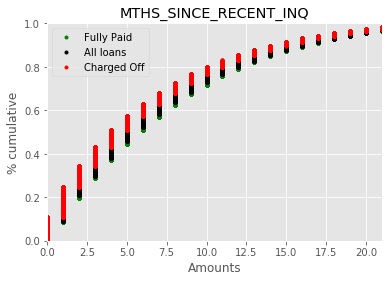

          All loans    Fully Paid    Charged Off
count  2.178022e+06  1.728400e+06  449622.000000
mean   6.709784e+00  6.877605e+00       6.064663
std    5.851616e+00  5.897210e+00       5.626532
min    0.000000e+00  0.000000e+00       0.000000
25%    2.000000e+00  2.000000e+00       2.000000
50%    5.000000e+00  5.000000e+00       4.000000
75%    1.000000e+01  1.000000e+01       9.000000
max    2.500000e+01  2.500000e+01      25.000000


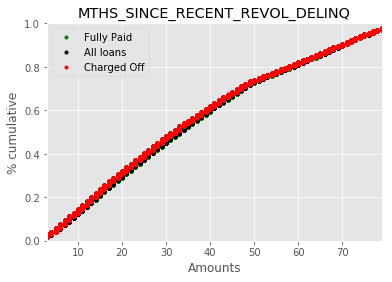

           All loans     Fully Paid    Charged Off
count  840150.000000  666938.000000  173212.000000
mean       35.804230      35.946757      35.255444
std        22.445003      22.423377      22.519725
min         0.000000       0.000000       0.000000
25%        17.000000      17.000000      16.000000
50%        33.000000      33.000000      32.000000
75%        52.000000      52.000000      52.000000
max       197.000000     197.000000     180.000000


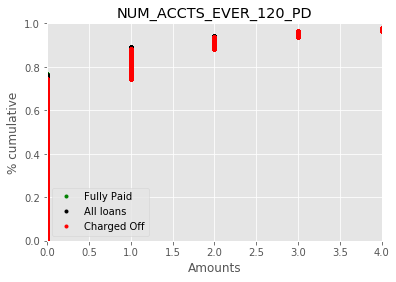

          All loans    Fully Paid    Charged Off
count  2.372586e+06  1.895102e+06  477484.000000
mean   5.094880e-01  5.024500e-01       0.537421
std    1.321659e+00  1.316326e+00       1.342253
min    0.000000e+00  0.000000e+00       0.000000
25%    0.000000e+00  0.000000e+00       0.000000
50%    0.000000e+00  0.000000e+00       0.000000
75%    0.000000e+00  0.000000e+00       1.000000
max    5.100000e+01  5.100000e+01      34.000000


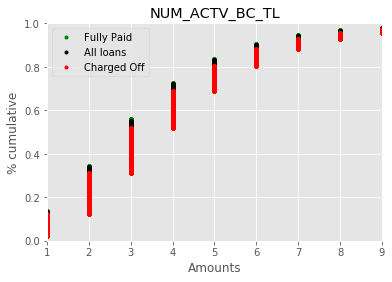

          All loans    Fully Paid    Charged Off
count  2.372586e+06  1.895102e+06  477484.000000
mean   3.650632e+00  3.603211e+00       3.838843
std    2.241497e+00  2.208431e+00       2.358803
min    0.000000e+00  0.000000e+00       0.000000
25%    2.000000e+00  2.000000e+00       2.000000
50%    3.000000e+00  3.000000e+00       3.000000
75%    5.000000e+00  5.000000e+00       5.000000
max    3.500000e+01  3.500000e+01      30.000000


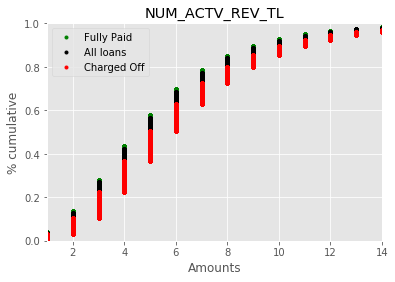

          All loans    Fully Paid    Charged Off
count  2.372586e+06  1.895102e+06  477484.000000
mean   5.662781e+00  5.542779e+00       6.139058
std    3.293362e+00  3.218048e+00       3.536755
min    0.000000e+00  0.000000e+00       0.000000
25%    3.000000e+00  3.000000e+00       4.000000
50%    5.000000e+00  5.000000e+00       5.000000
75%    7.000000e+00  7.000000e+00       8.000000
max    6.300000e+01  6.300000e+01      47.000000


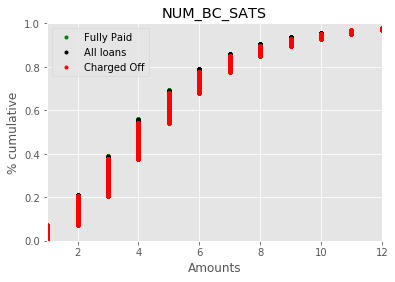

          All loans    Fully Paid    Charged Off
count  2.395958e+06  1.914366e+06  481592.000000
mean   4.732535e+00  4.711289e+00       4.816990
std    2.938490e+00  2.920538e+00       3.007312
min    0.000000e+00  0.000000e+00       0.000000
25%    3.000000e+00  3.000000e+00       3.000000
50%    4.000000e+00  4.000000e+00       4.000000
75%    6.000000e+00  6.000000e+00       6.000000
max    6.300000e+01  6.300000e+01      44.000000


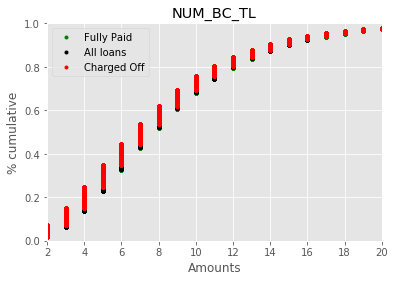

          All loans    Fully Paid    Charged Off
count  2.372586e+06  1.895102e+06  477484.000000
mean   8.155501e+00  8.195917e+00       7.995095
std    4.811194e+00  4.815596e+00       4.790325
min    0.000000e+00  0.000000e+00       0.000000
25%    5.000000e+00  5.000000e+00       5.000000
50%    7.000000e+00  7.000000e+00       7.000000
75%    1.100000e+01  1.100000e+01      10.000000
max    7.000000e+01  7.000000e+01      57.000000


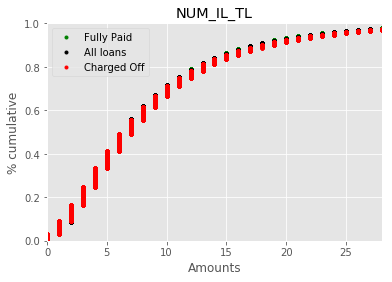

          All loans    Fully Paid    Charged Off
count  2.372586e+06  1.895102e+06  477484.000000
mean   8.575470e+00  8.544174e+00       8.699680
std    7.378384e+00  7.308073e+00       7.649823
min    0.000000e+00  0.000000e+00       0.000000
25%    4.000000e+00  4.000000e+00       4.000000
50%    7.000000e+00  7.000000e+00       7.000000
75%    1.100000e+01  1.100000e+01      12.000000
max    1.500000e+02  1.500000e+02     128.000000


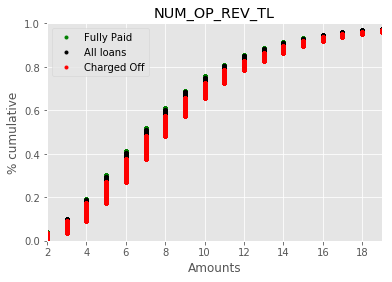

          All loans    Fully Paid    Charged Off
count  2.372586e+06  1.895102e+06  477484.000000
mean   8.290561e+00  8.211287e+00       8.605197
std    4.542967e+00  4.501332e+00       4.691396
min    0.000000e+00  0.000000e+00       0.000000
25%    5.000000e+00  5.000000e+00       5.000000
50%    7.000000e+00  7.000000e+00       8.000000
75%    1.000000e+01  1.000000e+01      11.000000
max    8.300000e+01  8.300000e+01      72.000000


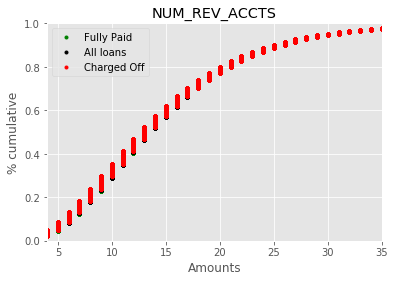

          All loans    Fully Paid    Charged Off
count  2.372584e+06  1.895100e+06  477484.000000
mean   1.469201e+01  1.470639e+01      14.634966
std    8.123022e+00  8.110228e+00       8.173361
min    0.000000e+00  1.000000e+00       0.000000
25%    9.000000e+00  9.000000e+00       9.000000
50%    1.300000e+01  1.300000e+01      13.000000
75%    1.900000e+01  1.900000e+01      19.000000
max    1.280000e+02  1.280000e+02     101.000000


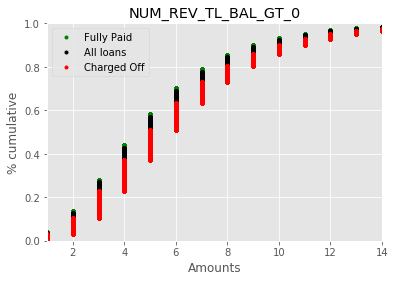

          All loans    Fully Paid    Charged Off
count  2.372586e+06  1.895102e+06  477484.000000
mean   5.613787e+00  5.498290e+00       6.072187
std    3.210057e+00  3.139009e+00       3.439732
min    0.000000e+00  0.000000e+00       0.000000
25%    3.000000e+00  3.000000e+00       4.000000
50%    5.000000e+00  5.000000e+00       5.000000
75%    7.000000e+00  7.000000e+00       8.000000
max    4.500000e+01  4.500000e+01      44.000000


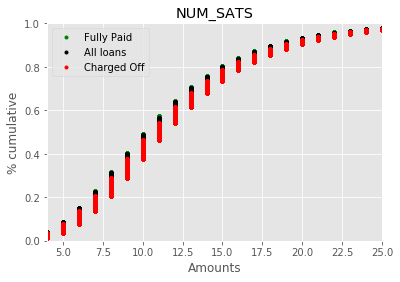

          All loans    Fully Paid    Charged Off
count  2.395958e+06  1.914366e+06  481592.000000
mean   1.165207e+01  1.157179e+01      11.971196
std    5.465617e+00  5.422393e+00       5.622844
min    0.000000e+00  0.000000e+00       0.000000
25%    8.000000e+00  8.000000e+00       8.000000
50%    1.100000e+01  1.100000e+01      11.000000
75%    1.400000e+01  1.400000e+01      15.000000
max    9.000000e+01  9.000000e+01      76.000000


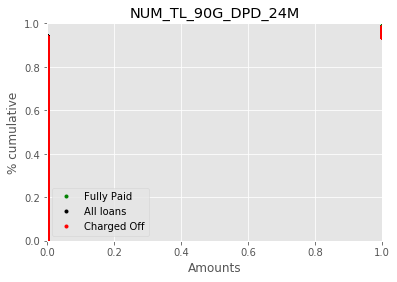

          All loans    Fully Paid    Charged Off
count  2.372586e+06  1.895102e+06  477484.000000
mean   8.935314e-02  8.684915e-02       0.099291
std    5.035921e-01  4.978564e-01       0.525623
min    0.000000e+00  0.000000e+00       0.000000
25%    0.000000e+00  0.000000e+00       0.000000
50%    0.000000e+00  0.000000e+00       0.000000
75%    0.000000e+00  0.000000e+00       0.000000
max    3.900000e+01  3.900000e+01      26.000000


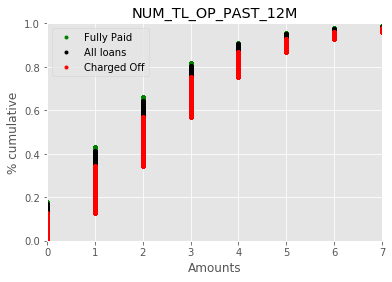

          All loans    Fully Paid    Charged Off
count  2.372586e+06  1.895102e+06  477484.000000
mean   2.177679e+00  2.096627e+00       2.499368
std    1.839439e+00  1.794184e+00       1.976523
min    0.000000e+00  0.000000e+00       0.000000
25%    1.000000e+00  1.000000e+00       1.000000
50%    2.000000e+00  2.000000e+00       2.000000
75%    3.000000e+00  3.000000e+00       3.000000
max    3.200000e+01  3.000000e+01      32.000000


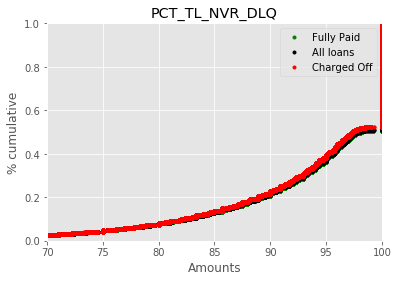

          All loans    Fully Paid    Charged Off
count  2.372278e+06  1.894838e+06  477440.000000
mean   9.417116e+01  9.421456e+01      93.998945
std    8.709222e+00  8.695504e+00       8.761343
min    0.000000e+00  0.000000e+00      10.500000
25%    9.130000e+01  9.140000e+01      90.900000
50%    9.790000e+01  9.800000e+01      97.400000
75%    1.000000e+02  1.000000e+02     100.000000
max    1.000000e+02  1.000000e+02     100.000000


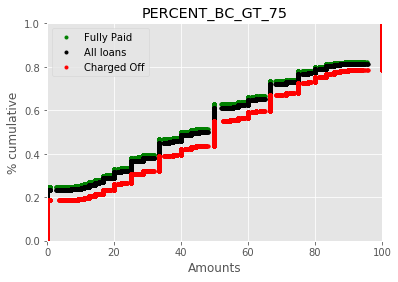

          All loans    Fully Paid    Charged Off
count  2.386984e+06  1.908058e+06  478926.000000
mean   4.572829e+01  4.446895e+01      50.745542
std    3.593945e+01  3.589976e+01      35.658311
min    0.000000e+00  0.000000e+00       0.000000
25%    1.250000e+01  8.300000e+00      20.000000
50%    5.000000e+01  4.000000e+01      50.000000
75%    7.500000e+01  7.500000e+01      80.000000
max    1.000000e+02  1.000000e+02     100.000000


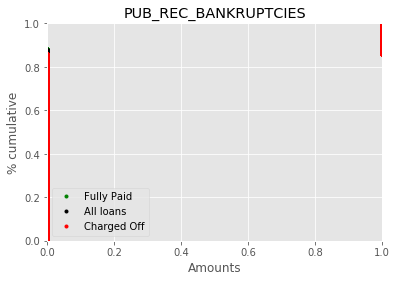

          All loans    Fully Paid    Charged Off
count  2.506246e+06  2.008362e+06  497884.000000
mean   1.340387e-01  1.293243e-01       0.153056
std    3.783036e-01  3.711287e-01       0.405405
min    0.000000e+00  0.000000e+00       0.000000
25%    0.000000e+00  0.000000e+00       0.000000
50%    0.000000e+00  0.000000e+00       0.000000
75%    0.000000e+00  0.000000e+00       0.000000
max    1.200000e+01  1.200000e+01      11.000000


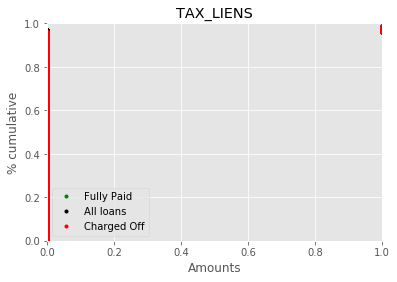

          All loans    Fully Paid    Charged Off
count  2.507562e+06  2.009444e+06  498118.000000
mean   5.229302e-02  5.029053e-02       0.060371
std    3.989664e-01  3.851293e-01       0.450401
min    0.000000e+00  0.000000e+00       0.000000
25%    0.000000e+00  0.000000e+00       0.000000
50%    0.000000e+00  0.000000e+00       0.000000
75%    0.000000e+00  0.000000e+00       0.000000
max    8.500000e+01  6.300000e+01      85.000000


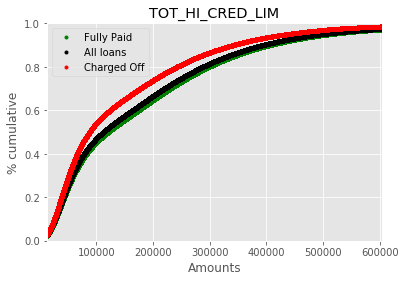

          All loans    Fully Paid   Charged Off
count  2.372586e+06  1.895102e+06  4.774840e+05
mean   1.739312e+05  1.809343e+05  1.461361e+05
std    1.771815e+05  1.825393e+05  1.509192e+05
min    0.000000e+00  0.000000e+00  0.000000e+00
25%    4.955000e+04  5.101200e+04  4.479100e+04
50%    1.123000e+05  1.208150e+05  8.800000e+04
75%    2.515330e+05  2.618410e+05  2.076100e+05
max    9.999999e+06  9.999999e+06  9.999999e+06


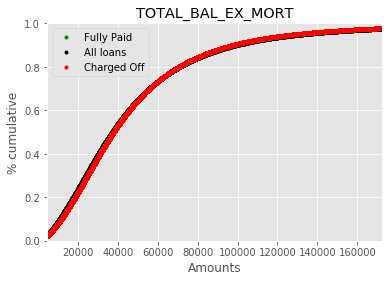

          All loans    Fully Paid   Charged Off
count  2.413078e+06  1.928730e+06  4.843480e+05
mean   4.957939e+04  4.964393e+04  4.932238e+04
std    4.754079e+04  4.825293e+04  4.459140e+04
min    0.000000e+00  0.000000e+00  0.000000e+00
25%    2.094800e+04  2.073900e+04  2.179600e+04
50%    3.729700e+04  3.713300e+04  3.792100e+04
75%    6.240800e+04  6.242600e+04  6.235000e+04
max    3.408095e+06  3.408095e+06  1.896461e+06


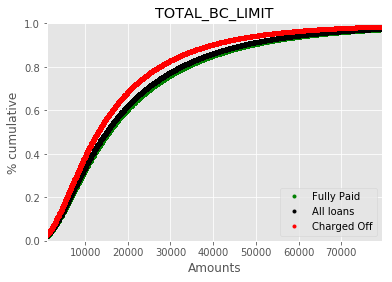

          All loans    Fully Paid    Charged Off
count  2.413078e+06  1.928730e+06  484348.000000
mean   2.147833e+04  2.225887e+04   18370.093941
std    2.138888e+04  2.204602e+04   18213.620496
min    0.000000e+00  0.000000e+00       0.000000
25%    7.700000e+03  8.000000e+03    6800.000000
50%    1.500000e+04  1.550000e+04   13000.000000
75%    2.790000e+04  2.900000e+04   23700.000000
max    1.105500e+06  1.105500e+06  560800.000000


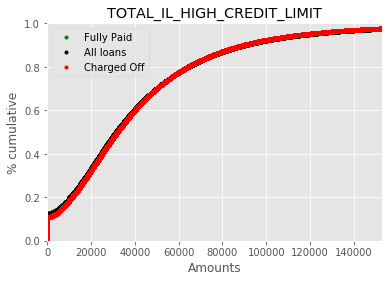

          All loans    Fully Paid    Charged Off
count  2.372586e+06  1.895102e+06  477484.000000
mean   4.195803e+04  4.196216e+04   41941.624884
std    4.306059e+04  4.346998e+04   41395.855784
min    0.000000e+00  0.000000e+00       0.000000
25%    1.468900e+04  1.450000e+04   15021.000000
50%    3.157300e+04  3.143900e+04   32084.500000
75%    5.638500e+04  5.638400e+04   56390.000000
max    2.101913e+06  2.101913e+06  954503.000000


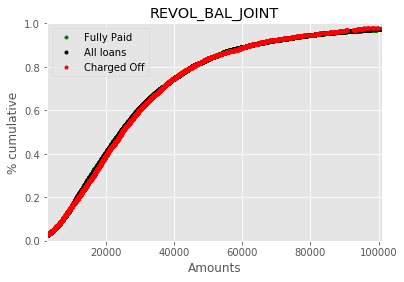

           All loans     Fully Paid    Charged Off
count   23510.000000   18478.000000    5032.000000
mean    31181.272140   31224.293755   31023.292528
std     26484.346638   26965.958231   24637.093790
min         0.000000       0.000000       0.000000
25%     13672.000000   13574.000000   14247.500000
50%     24385.000000   24255.000000   24798.000000
75%     40338.000000   40331.750000   40406.000000
max    290237.000000  290237.000000  266416.000000


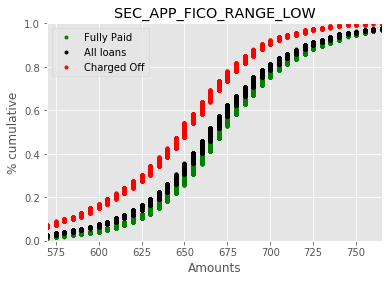

          All loans    Fully Paid  Charged Off
count  23510.000000  18478.000000  5032.000000
mean     666.704806    672.540318   645.276232
std       45.242020     43.807192    43.956272
min      540.000000    540.000000   540.000000
25%      640.000000    645.000000   620.000000
50%      665.000000    670.000000   650.000000
75%      690.000000    695.000000   675.000000
max      830.000000    830.000000   805.000000


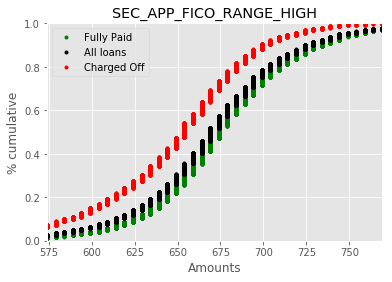

          All loans    Fully Paid  Charged Off
count  23510.000000  18478.000000  5032.000000
mean     670.704806    676.540318   649.276232
std       45.242020     43.807192    43.956272
min      544.000000    544.000000   544.000000
25%      644.000000    649.000000   624.000000
50%      669.000000    674.000000   654.000000
75%      694.000000    699.000000   679.000000
max      834.000000    834.000000   809.000000


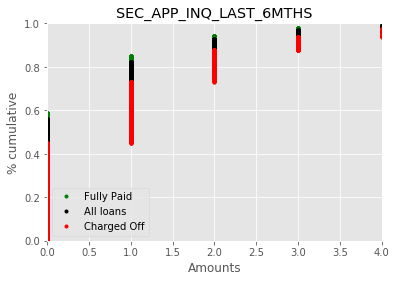

          All loans    Fully Paid  Charged Off
count  23510.000000  18478.000000  5032.000000
mean       0.735262      0.653859     1.034181
std        1.074143      0.995038     1.281190
min        0.000000      0.000000     0.000000
25%        0.000000      0.000000     0.000000
50%        0.000000      0.000000     1.000000
75%        1.000000      1.000000     2.000000
max        6.000000      6.000000     6.000000


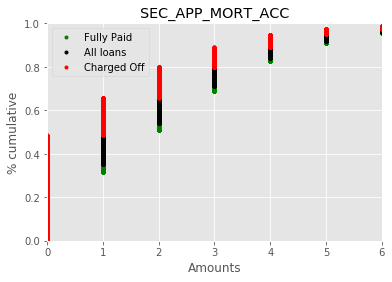

          All loans    Fully Paid  Charged Off
count  23510.000000  18478.000000  5032.000000
mean       1.713228      1.834506     1.267886
std        1.839451      1.864779     1.669520
min        0.000000      0.000000     0.000000
25%        0.000000      0.000000     0.000000
50%        1.000000      1.000000     1.000000
75%        3.000000      3.000000     2.000000
max       17.000000     17.000000    13.000000


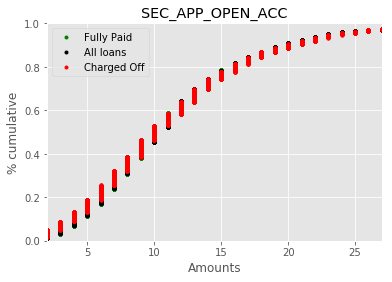

          All loans    Fully Paid  Charged Off
count  23510.000000  18478.000000  5032.000000
mean      11.307529     11.325360    11.242051
std        6.493083      6.454004     6.634855
min        0.000000      0.000000     0.000000
25%        7.000000      7.000000     6.000000
50%       10.000000     10.000000    10.000000
75%       15.000000     15.000000    15.000000
max       58.000000     58.000000    44.000000


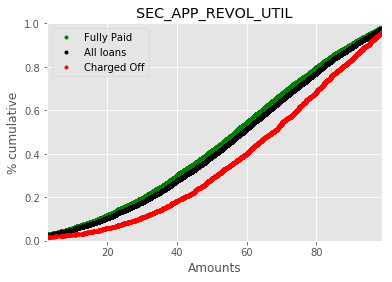

          All loans    Fully Paid  Charged Off
count  23126.000000  18248.000000  4878.000000
mean      56.965761     55.025986    64.222222
std       26.394349     26.369650    25.197906
min        0.000000      0.000000     0.000000
25%       37.800000     35.600000    47.125000
50%       58.900000     56.600000    67.500000
75%       78.200000     76.100000    84.100000
max      163.900000    155.000000   163.900000


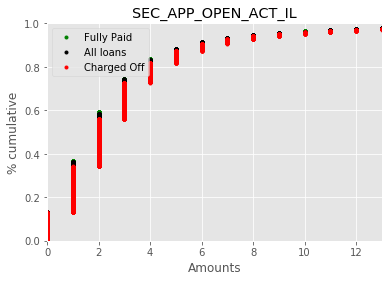

          All loans    Fully Paid  Charged Off
count  23510.000000  18478.000000  5032.000000
mean       2.916376      2.878775     3.054452
std        3.237409      3.184368     3.421932
min        0.000000      0.000000     0.000000
25%        1.000000      1.000000     1.000000
50%        2.000000      2.000000     2.000000
75%        4.000000      4.000000     4.000000
max       35.000000     35.000000    33.000000


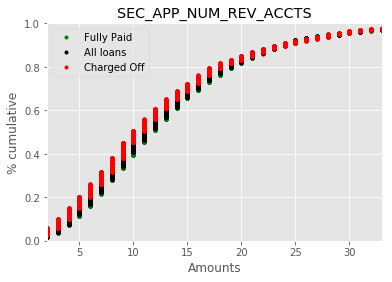

          All loans    Fully Paid  Charged Off
count  23510.000000  18478.000000  5032.000000
mean      12.848915     13.006386    12.270668
std        8.352366      8.340657     8.370678
min        0.000000      0.000000     0.000000
25%        7.000000      7.000000     6.000000
50%       11.000000     11.000000    10.000000
75%       17.000000     17.000000    16.000000
max       90.000000     90.000000    61.000000


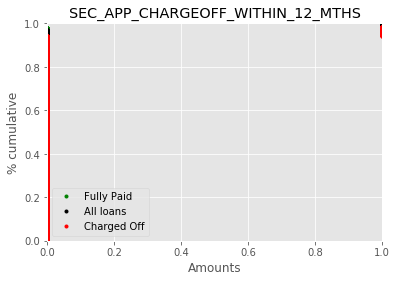

          All loans    Fully Paid  Charged Off
count  23510.000000  18478.000000  5032.000000
mean       0.049851      0.037666     0.094595
std        0.429345      0.356917     0.625276
min        0.000000      0.000000     0.000000
25%        0.000000      0.000000     0.000000
50%        0.000000      0.000000     0.000000
75%        0.000000      0.000000     0.000000
max       20.000000     14.000000    20.000000


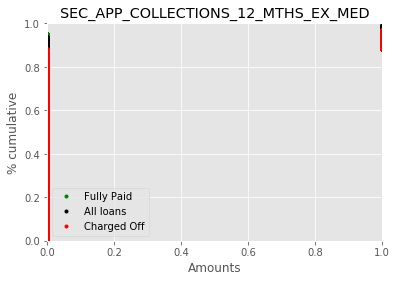

          All loans    Fully Paid  Charged Off
count  23510.000000  18478.000000  5032.000000
mean       0.082178      0.057582     0.172496
std        0.387895      0.293415     0.613612
min        0.000000      0.000000     0.000000
25%        0.000000      0.000000     0.000000
50%        0.000000      0.000000     0.000000
75%        0.000000      0.000000     0.000000
max       11.000000     10.000000    11.000000


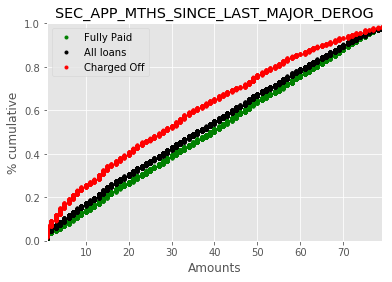

         All loans   Fully Paid  Charged Off
count  8338.000000  6120.000000  2218.000000
mean     37.139842    39.332026    31.091073
std      23.895275    23.671229    23.468821
min       0.000000     0.000000     0.000000
25%      16.000000    18.000000    10.000000
50%      36.000000    39.000000    28.000000
75%      57.000000    59.000000    49.000000
max     125.000000   125.000000   115.000000


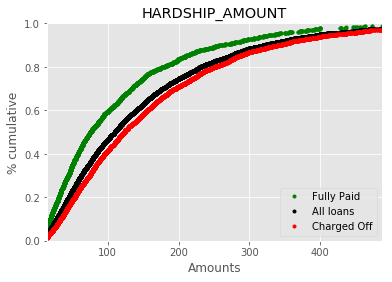

          All loans   Fully Paid  Charged Off
count  10028.000000  2886.000000  7142.000000
mean     147.370377   113.423708   161.087835
std      128.257327   109.327087   132.722824
min        0.640000     0.640000     1.610000
25%       53.470000    37.110000    62.490000
50%      110.005000    75.430000   123.050000
75%      203.350000   151.367500   223.142500
max      943.940000   781.050000   943.940000


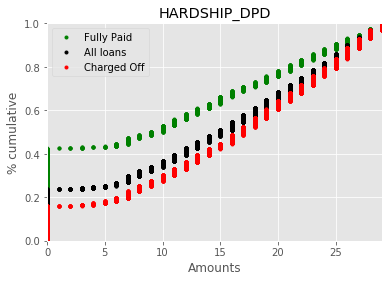

          All loans   Fully Paid  Charged Off
count  10028.000000  2886.000000  7142.000000
mean      13.885919    10.158004    15.392327
std        9.816231    10.180893     9.248765
min        0.000000     0.000000     0.000000
25%        5.000000     0.000000     8.000000
50%       15.000000     9.000000    17.000000
75%       23.000000    19.000000    23.000000
max       37.000000    37.000000    32.000000


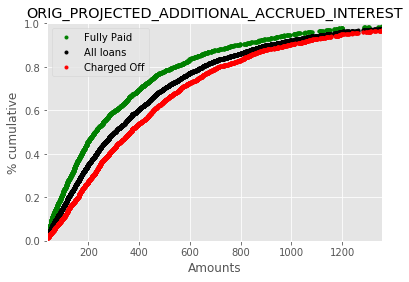

         All loans   Fully Paid  Charged Off
count  6464.000000  2718.000000  3746.000000
mean    413.094124   340.088212   466.065312
std     360.378648   324.602863   375.514912
min       1.920000     1.920000     6.450000
25%     147.892500   111.667500   186.210000
50%     305.775000   226.050000   365.220000
75%     569.587500   457.297500   637.620000
max    2343.150000  2343.150000  2267.280000


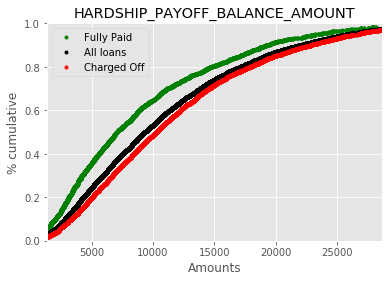

          All loans    Fully Paid   Charged Off
count  10028.000000   2886.000000   7142.000000
mean   10982.148993   9137.133479  11727.698527
std     7430.650925   7065.228355   7445.179915
min       55.730000     55.730000    191.120000
25%     5075.960000   3665.052500   5887.255000
50%     9320.405000   7047.270000  10268.590000
75%    15284.330000  12907.110000  15971.587500
max    39542.450000  39542.450000  38399.000000


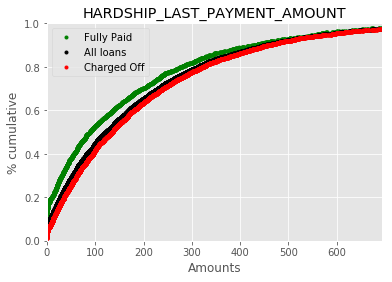

          All loans   Fully Paid  Charged Off
count  10028.000000  2886.000000  7142.000000
mean     184.276039   159.735835   194.192453
std      195.456440   190.567957   196.543184
min        0.010000     0.010000     0.010000
25%       39.360000    20.302500    48.935000
50%      121.960000    89.170000   135.320000
75%      267.080000   233.952500   279.615000
max     1407.860000  1247.480000  1407.860000


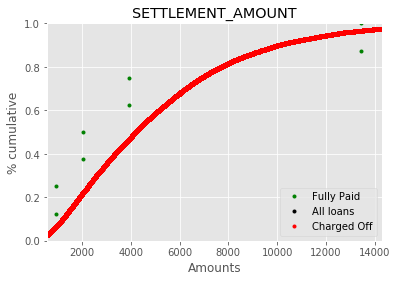

          All loans    Fully Paid   Charged Off
count  61484.000000      8.000000  61476.000000
mean    5045.485081   5091.385000   5045.479108
std     3662.768623   5287.072766   3662.572405
min       44.210000    926.000000     44.210000
25%     2250.970000   1775.750000   2251.000000
50%     4203.230000   2992.770000   4203.675000
75%     6906.000000   6308.405000   6906.000000
max    33601.000000  13454.000000  33601.000000


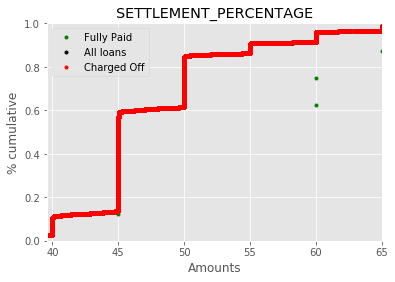

          All loans  Fully Paid   Charged Off
count  61484.000000    8.000000  61476.000000
mean      47.600147   53.750000     47.599346
std        7.321847    9.543135      7.321279
min        0.200000   45.000000      0.200000
25%       45.000000   45.000000     45.000000
50%       45.000000   52.500000     45.000000
75%       50.000000   61.250000     50.000000
max      521.350000   65.000000    521.350000


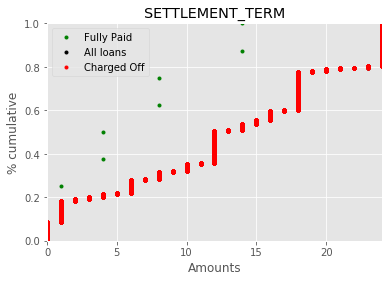

          All loans  Fully Paid   Charged Off
count  61484.000000    8.000000  61476.000000
mean      12.972741    6.750000     12.973551
std        8.321026    5.203021      8.321079
min        0.000000    1.000000      0.000000
25%        6.000000    3.250000      6.000000
50%       12.000000    6.000000     12.000000
75%       18.000000    9.500000     18.000000
max      181.000000   14.000000    181.000000


In [9]:
for thing in numeric:
    numeric_graph(thing)